In [67]:
import numpy as np
import pandas as pd
import zipfile
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D , Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D, GlobalAveragePooling2D, Rescaling
from keras.applications import VGG16
from keras import optimizers
from keras.models import Model
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings 
warnings.filterwarnings('ignore')


<function keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>

In [2]:
path_zip = '/kaggle/input/dogs-vs-cats/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip+'train.zip','r') as zip_ref:
    zip_ref.extractall(path+'train')
with zipfile.ZipFile(path_zip+'test1.zip','r') as zip_ref:
    zip_ref.extractall(path+'test')

In [3]:
filenames = os.listdir("/kaggle/working/train/train")
categories=[]

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

df.head()

,filename,category
0,cat.3720.jpg,0
1,cat.11142.jpg,0
2,dog.4495.jpg,1
3,dog.12050.jpg,1
4,dog.5141.jpg,1


<AxesSubplot:>

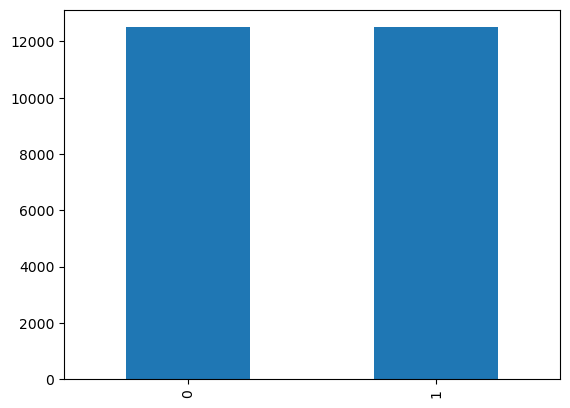

In [4]:
df['category'].value_counts().plot.bar()

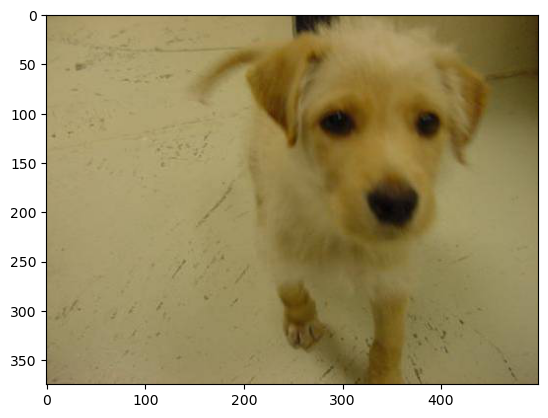

In [5]:
sample =random.choice(filenames)
img = np.asarray(Image.open("/kaggle/working/train/train/"+sample))
plt.imshow(img)

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [9]:
train_df['category']=train_df['category'].astype(str)
validate_df['category']=validate_df['category'].astype(str)

In [28]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 10
batch_size = 16

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [30]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [31]:
print(validation_generator.class_indices)
print(validation_generator.n)
print(len(validation_generator))

{'0': 0, '1': 1}
5000
313


Found 1 validated image filenames belonging to 1 classes.


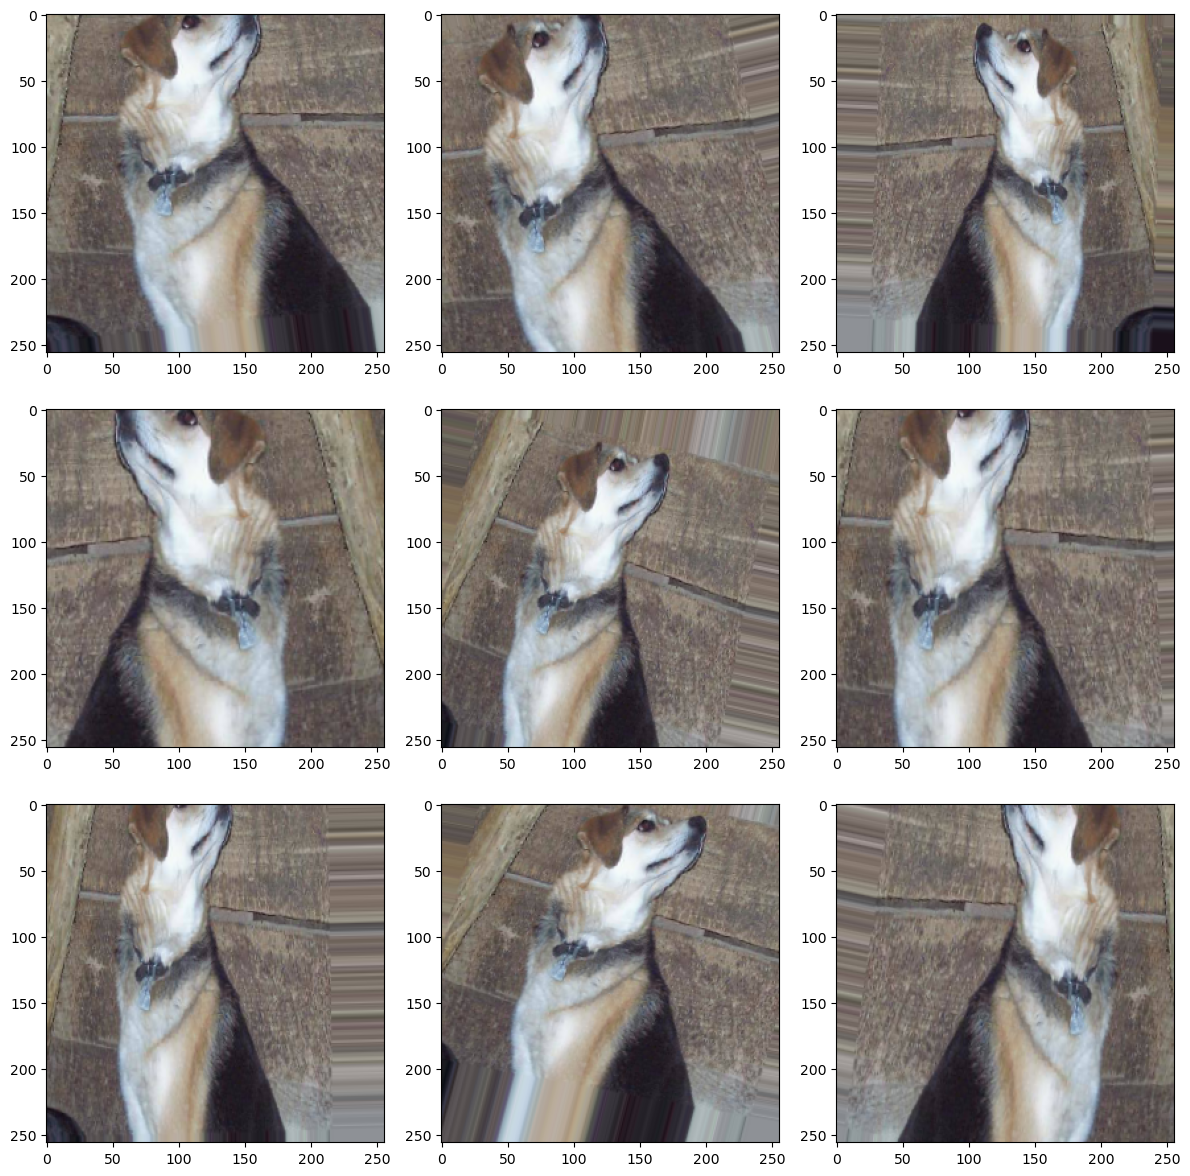

In [32]:
example_df = train_df.sample(n=1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/kaggle/working/train/train/",
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [97]:
import tensorflow_hub as hub
    
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
    hub.KerasLayer("https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/152-classification/versions/2"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")],

)
model.build([(None, 224, 224, 3)])  # Batch input shape.



In [98]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] 
  )
model.build(input_shape)
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_15 (KerasLayer)  (None, 1001)             60382697  
                                                                 
 dense_26 (Dense)            (None, 512)               513024    
                                                                 
 dense_27 (Dense)            (None, 1)                 513       
                                                                 
Total params: 60,896,234
Trainable params: 513,537
Non-trainable params: 60,382,697
_________________________________________________________________


In [99]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/10
  43/1250 [>.............................] - ETA: 1:01:47 - loss: 0.0000e+00 - accuracy: 0.4869

KeyboardInterrupt: 